In [1]:
!pip3 install ufal.udpipe spacy nltk scikit-learn

In [2]:
# Standard library and basic data wrangling
import os
import urllib
import urllib.request
import re
import regex
import pandas as pd
import numpy as np

# Tokenization
import nltk
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nagisa

# For plotting word clouds
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Natural language processing
import spacy
import ufal.udpipe
from gensim.models import KeyedVectors, Phrases
from gensim.sklearn_api.phrases import PhrasesTransformer
from ufal.udpipe import Model, Pipeline
import conllu

In [3]:
texts = ["The caged bird sings with a fearful trill", 
         "for the caged bird sings of freedom"]
cv = CountVectorizer()
d = cv.fit_transform(texts)
# Create a dataframe of the word counts to inspect
# - d.todense() transforms the dtm into a normal (dense) matrix
# - get_feature_names() is a list of the words
pd.DataFrame(d.todense(), columns=cv.get_feature_names()) 

,bird,caged,fearful,for,freedom,of,sings,the,trill,with
0,1,1,1,0,0,0,1,1,1,1
1,1,1,0,1,1,1,1,1,0,0


In [4]:
text = "I haven't seen John's derring-do"
tokenizer = CountVectorizer().build_tokenizer()
print(tokenizer(text))



['haven', 'seen', 'John', 'derring', 'do']


In [5]:
text = "I haven't seen John's derring-do. Second sentence!"
print(TreebankWordTokenizer().tokenize(text))


['I', 'have', "n't", 'seen', 'John', "'s", 'derring-do.', 'Second', 'sentence', '!']


In [6]:
print(WhitespaceTokenizer().tokenize(text))

['I', "haven't", 'seen', "John's", 'derring-do.', 'Second', 'sentence!']


In [7]:
nltk.download('punkt')
class MyTokenizer:
    def tokenize(self, text):
        result = []
        word = r"\p{letter}"
        for sent in nltk.sent_tokenize(text):
            tokens = TreebankWordTokenizer().tokenize(sent)    
            tokens = [t for t in tokens if regex.search(word, t)]
            result += tokens
        return result
mytokenizer = MyTokenizer()
print(mytokenizer.tokenize(text))

['I', 'have', "n't", 'seen', 'John', "'s", 'derring-do', 'Second', 'sentence']


[nltk_data] Downloading package punkt to /home/damian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# this snippet uses the tokenizer created in the box "Tokenization with Python"
haiku = "\u53e4\u6c60\u86d9\u98db\u3073\u8fbc\u3080\u6c34\u306e\u97f3"
print(f"Default tokens: {mytokenizer.tokenize(haiku)}")
print(f"Nagisa tokens: {nagisa.tagging(haiku).words}")

Default tokens: ['古池蛙飛び込む水の音']
Nagisa tokens: ['古', '池蛙', '飛び込む', '水', 'の', '音']


In [9]:
# this snippet uses the tokenizer created in the box "Tokenization with Python"
sotu = pd.read_csv("http://cssbook.net/d/sotu.csv")
cv = CountVectorizer(tokenizer=mytokenizer.tokenize)
d = cv.fit_transform(sotu["text"])
d

<85x17185 sparse matrix of type '<class 'numpy.int64'>'
	with 132900 stored elements in Compressed Sparse Row format>

In [10]:
def termstats(dfm, vectorizer):
    """Helper function to calculate term and document frequency per term"""
    # Frequencies are the column sums of the DFM
    frequencies = dfm.sum(axis=0).tolist()[0]
    # Document frequencies are the binned count of the column indices of DFM entries
    docfreqs = np.bincount(dfm.indices)
    freq_df = pd.DataFrame(dict(frequency=frequencies,
                                docfreq=docfreqs), index=vectorizer.get_feature_names())
    return freq_df.sort_values('frequency', ascending=False)

termstats(d, cv).iloc[[0, 10,  100,  1000, 15000]]

,frequency,docfreq
the,34996,85
is,5472,85
energy,707,68
scientific,73,28
overwatch,1,1


In [11]:
indices = [cv.vocabulary_[x] for x in ["the", "is", "energy", "scientific", "overwatch"]]
d[[[0], [25], [50], [75]], indices].todense()

matrix([[642,  78,   0,   0,   0],
        [355,  66,   1,   0,   0],
        [182,  45,   2,   0,   0],
        [326,  59,  15,   1,   0]])

(-0.5, 399.5, 199.5, -0.5)

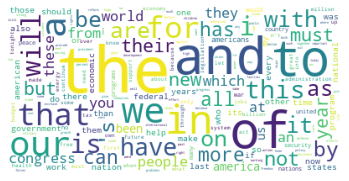

In [12]:
def wordcloud(dfm, vectorizer, **options):
    freq_dict = dict(zip(vectorizer.get_feature_names(),
                         dfm.sum(axis=0).tolist()[0]))
    return WordCloud(**options).generate_from_frequencies(freq_dict)

wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [13]:
url = "http://cssbook.net/d/trumptweets.csv"
tweets = pd.read_csv(url, usecols=["status_id", "text"], index_col="status_id")
tweets.head()

,text
status_id,
x1864367186,Read a great interview with Donald Trump that ...
x9273573134835712,Congratulations to Evan Lysacek for being nomi...
x29014512646,I was on The View this morning. We talked abou...
x7483813542232064,Tomorrow night's episode of The Apprentice del...
x5775731054,Donald Trump Partners with TV1 on New Reality ...


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(-0.5, 399.5, 199.5, -0.5)

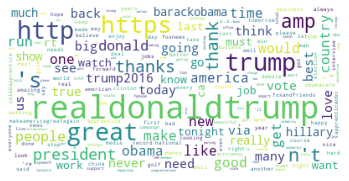

In [14]:
cv = CountVectorizer(stop_words=stopwords.words('english'), 
                     tokenizer=mytokenizer.tokenize)
d = cv.fit_transform(tweets.text)
wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [15]:
mystopwords = ["go", "one"] + stopwords.words('english')
print(f"{len(mystopwords)} stopwords: {', '.join(mystopwords[:5])}...")


181 stopwords: go, one, i, me, my...


In [16]:
cv_trim = CountVectorizer(stop_words=stopwords.words('english'), tokenizer=mytokenizer.tokenize, max_df=0.75, min_df=0.005)
d_trim = cv_trim.fit_transform(tweets.text)
print(f"# of unique words before trimming: {d.shape[1]}; after trimming: {d_trim.shape[1]}")


# of unique words before trimming: 45912; after trimming: 294


In [17]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=mytokenizer.tokenize, sublinear_tf=True)
d_weighted = tfidf_vectorizer.fit_transform(sotu["text"])
indices = [tfidf_vectorizer.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes"]]
d_weighted[[[0], [25], [50], [75]], indices].todense()

matrix([[0.04443888, 0.03107326, 0.01989122, 0.        , 0.        ],
        [0.05722359, 0.04138723, 0.02782201, 0.01429464, 0.        ],
        [0.0548183 , 0.04440376, 0.02332654, 0.        , 0.        ],
        [0.04866919, 0.03859479, 0.02234111, 0.        , 0.        ]])

In [18]:
single_tweet = tweets.text.values[tweets.index == "x263687274812813312"][0]
print(f"Raw:\n{single_tweet}")
tweet_tokens = mytokenizer.tokenize(single_tweet)
print(f"\nTokenized:\n{' | '.join(tweet_tokens)}")

Raw:
Part 1 of my @jimmyfallon interview discussing my $5M offer to Obama, #TRUMP Tower atrium, my tweets &amp; 57th st. crane http://t.co/AvLO9Inf

Tokenized:
Part | of | my | jimmyfallon | interview | discussing | my | 5M | offer | to | Obama | TRUMP | Tower | atrium | my | tweets | amp | 57th | st. | crane | http | //t.co/AvLO9Inf


In [19]:
single_tweet = re.sub(r"\bhttps?://\S*|&\w+;", "", single_tweet)
tweet_tokens = mytokenizer.tokenize(single_tweet)
print(f"After pre-processing:\n {' | '.join(tweet_tokens)}")

After pre-processing:
 Part | of | my | jimmyfallon | interview | discussing | my | 5M | offer | to | Obama | TRUMP | Tower | atrium | my | tweets | 57th | st. | crane


In [20]:
tweet_tokens = [t.lower() for t in tweet_tokens 
                if not (t.lower() in stopwords.words('english')
                        or regex.match(r"\P{LETTER}", t))]
print(f"After pruning tokens:\n{' | '.join(tweet_tokens)}")

After pruning tokens:
part | jimmyfallon | interview | discussing | offer | obama | trump | tower | atrium | tweets | st. | crane


(-0.5, 399.5, 199.5, -0.5)

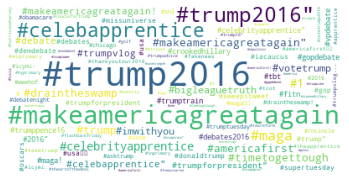

In [21]:
def do_nothing(x):
    return x

tokenized_texts = [WhitespaceTokenizer().tokenize(text) for text in tweets.text.values]
tokens = [[t.lower() for t in tokens 
           if regex.match("#", t) ]
          for tokens in tokenized_texts]

cv = CountVectorizer(tokenizer=do_nothing, lowercase=False)
dtm_emoji = cv.fit_transform(tokens)
wc = wordcloud(dtm_emoji, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [22]:
glove_fn = 'glove.6B.50d.10k.w2v.txt'
url = f'http://cssbook.net/d/{glove_fn}'
if not os.path.exists(glove_fn):
      urllib.request.urlretrieve (url, glove_fn)

In [23]:
wv = KeyedVectors.load_word2vec_format(glove_fn)
wvdf = pd.DataFrame(wv.vectors, index=wv.vocab)
wvdf.sort_values(0, ascending=False).head()

loading projection weights from glove.6B.50d.10k.w2v.txt
loaded (10000, 50) matrix from glove.6B.50d.10k.w2v.txt


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
airbus,2.5966,-0.53562,0.41422,0.339390,-0.050989,0.84761,-0.72224,-0.36125,0.86917,-0.73059,...,0.54601,-0.25080,1.31020,-0.24175,-0.30980,1.14690,-0.803920,1.505000,-0.066982,0.133350
spacecraft,2.5187,0.74418,1.66480,0.059079,-0.252150,-0.24264,-0.59439,-0.41732,0.45961,-0.12370,...,0.18188,-0.93961,0.86213,-0.52732,-0.71251,-0.30863,1.054500,-0.065039,-0.235400,-0.401210
fiat,2.2865,-1.14970,0.48850,0.518330,0.311980,-0.13188,0.05203,-0.66095,-0.85899,0.26276,...,-0.17639,-0.85392,0.35823,-0.69644,-0.31383,0.33382,-0.732300,0.173990,0.398950,0.042601
naples,2.2656,-0.10631,-1.27220,-0.093226,-0.437000,-1.18090,-0.08577,0.46925,-1.08410,-0.54926,...,0.01893,0.62688,0.54075,-0.58529,-0.42509,0.67343,-0.152420,-0.857650,0.211240,-0.279690
di,2.2441,-0.60324,-1.46890,0.354340,0.243670,-1.08890,0.35689,-0.33070,-0.56399,0.42835,...,0.46470,0.26903,-0.36234,-0.94564,-0.19706,-1.19640,0.000371,-1.229200,0.805580,0.775450


In [24]:
wv.most_similar('fraud')

precomputing L2-norms of word weight vectors


[('charges', 0.8591151237487793),
 ('bribery', 0.8559849262237549),
 ('alleged', 0.8415061831474304),
 ('corruption', 0.8299385905265808),
 ('allegations', 0.8191749453544617),
 ('theft', 0.8025560975074768),
 ('criminal', 0.7997947931289673),
 ('investigating', 0.7920836806297302),
 ('investigation', 0.788571298122406),
 ('laundering', 0.7872843742370605)]

In [25]:
def analogy(a, b, c):
    result = wv.most_similar(positive=[b, c], negative=[a])
    return result[0][0]

for x in ["king", "boy", "father", "pete", "football"]:
    print(f"Man is to {x} as woman is to {analogy('man', x, 'woman')}")

Man is to king as woman is to queen
Man is to boy as woman is to girl
Man is to father as woman is to mother
Man is to pete as woman is to barbara
Man is to football as woman is to soccer


In [26]:
cv = CountVectorizer(ngram_range=(1,3), tokenizer=mytokenizer.tokenize)
cv.fit_transform(["This is a test"])
cv.get_feature_names()

['a',
 'a test',
 'is',
 'is a',
 'is a test',
 'test',
 'this',
 'this is',
 'this is a']

In [27]:
cv = CountVectorizer(ngram_range=(1,2), tokenizer=mytokenizer.tokenize, stop_words='english')
dfm = cv.fit_transform(sotu.text.values)
termstats(dfm, cv).filter(like='government', axis=0).head(10)

,frequency,docfreq
government,1493,84
federal government,278,56
governments,188,50
local governments,104,28
government 's,79,27
governmental,41,19
local government,32,16
government spending,30,20
self-government,26,20
government programs,23,17


In [28]:
tokenized_texts = [mytokenizer.tokenize(t) for t in sotu.text]
tokens = [[t.lower() for t in tokens 
           if not regex.search("\P{letter}", t) ]
           for tokens in tokenized_texts]
p = Phrases(tokens, min_count=10, scoring="npmi", threshold=.5)
score_data = [(w1.decode('utf-8'), w2.decode('utf-8'), score) 
              for (w1, w2), score in set(p.export_phrases(tokens, as_tuples=True))]
scores = pd.DataFrame(score_data, columns=['word1', 'word2', 'score'])
scores.sort_values("score", ascending=False).head()

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words and 0 word types
collected 200027 word types from a corpus of 578783 words (unigram + bigrams) and 85 sentences
using 200027 counts as vocab in Phrases<0 vocab, min_count=10, threshold=0.5, max_vocab_size=40000000>


,word1,word2,score
30,iron,curtain,0.977816
237,saddam,hussein,0.975395
96,al,qaida,0.963029
112,red,tape,0.952860
273,persian,gulf,0.951335


In [29]:
pt = PhrasesTransformer(min_count=10, threshold=.7, scoring="npmi")
tokens_phrases = pt.fit_transform(tokens)
cv = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
dtm = cv.fit_transform(tokens_phrases)
termstats(dtm, cv).filter(like="hussein", axis=0)



collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words and 0 word types
collected 200027 word types from a corpus of 578783 words (unigram + bigrams) and 85 sentences
using 200027 counts as vocab in Phrases<0 vocab, min_count=10, threshold=0.7, max_vocab_size=40000000>
source_vocab length 200027
Phraser built with 87 phrasegrams


,frequency,docfreq
saddam_hussein,29,5


In [30]:
udpipe_model = "english-ewt-ud-2.4-190531.udpipe"
url = "https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.4/master/inst/udpipe-ud-2.4-190531/english-ewt-ud-2.4-190531.udpipe"
if not os.path.exists(udpipe_model):
    urllib.request.urlretrieve(url, udpipe_model)

In [31]:
m = Model.load(udpipe_model)
pipeline = Pipeline(m, "tokenize", Pipeline.DEFAULT, Pipeline.DEFAULT, "conllu")
tokenlist = conllu.parse(pipeline.process("John bought new knives")) 
pd.DataFrame(tokenlist[0])

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc
0,1,John,John,PROPN,NNP,{'Number': 'Sing'},2,nsubj,None,None
1,2,bought,buy,VERB,VBD,"{'Mood': 'Ind', 'Tense': 'Past', 'VerbForm': '...",0,root,None,None
2,3,new,new,ADJ,JJ,{'Degree': 'Pos'},4,amod,None,None
3,4,knives,knife,NOUN,NNS,{'Number': 'Plur'},2,obj,None,{'SpacesAfter': '\n'}


(-0.5, 399.5, 199.5, -0.5)

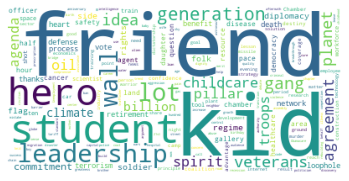

In [32]:
def get_nouns(text):
    for sentence in conllu.parse(pipeline.process(text)):
        for token in sentence:
            if token['upos'] == "NOUN":
                yield token['lemma']

parser = Pipeline.NONE
pipeline = Pipeline(m, "tokenize", Pipeline.DEFAULT, Pipeline.NONE, "conllu")
                
tokens = [list(get_nouns(text)) for text in sotu.text[-5:]]
cv = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_df=.7)
dtm_verbs = cv.fit_transform(tokens)
wc = wordcloud(dtm_verbs, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [33]:
!{sys.executable} -m spacy download es_core_news_sm
# Note: restart the kernel (and import spacy again) 
#       for the model to be found by python

/bin/bash: {sys.executable}: opdracht niet gevonden


In [5]:
nlp = spacy.load('es_core_news_sm')
tokens = nlp("Todos los caminos llevan a Roma")
pd.DataFrame([dict(i=t.i, word=t.text, lemma=t.lemma_, 
                   head=t.head, dep=t.dep_, ent_type=t.ent_type_)
             for t in tokens])

,i,word,lemma,head,dep,ent_type
0,0,Todos,Todos,los,det,
1,1,los,lo,caminos,det,
2,2,caminos,camino,llevan,nsubj,
3,3,llevan,llevar,llevan,ROOT,
4,4,a,a,Roma,case,
5,5,Roma,Roma,llevan,obj,LOC
